# Table of Contents
 <p><div class="lev1 toc-item"><a href="#let's-look-at-many-examples" data-toc-modified-id="let's-look-at-many-examples-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>let's look at many examples</a></div><div class="lev1 toc-item"><a href="#in-depth:-one-different-group" data-toc-modified-id="in-depth:-one-different-group-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>in depth: one different group</a></div><div class="lev1 toc-item"><a href="#in-depth:-3-different-groups" data-toc-modified-id="in-depth:-3-different-groups-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>in depth: 3 different groups</a></div>

This notebook works through the symmetry algorithm in RMG-Py 2.0 `rmgpy/molecule/symmetry/calculateCyclicSymmetryNumber` to highlight improper calculations of the algorithm.

The algorithm comes from [page 244 of Yu, Joanna's Thesis](https://dspace.mit.edu/handle/1721.1/33715#files-area)

In [65]:
from rdkit.Chem.rdmolops import SanitizeMol
from rdkit.Chem.rdchem import Mol 
import rmgpy.molecule
from rmgpy.molecule import Molecule
from rmgpy.molecule.symmetry import calculateCyclicSymmetryNumber

# let's look at many examples

this should have a symmetry number of 2

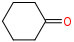

In [67]:
s1 = Molecule().fromSMILES('C1CCCCC1=O')
s1

In [68]:
calculateCyclicSymmetryNumber(s1)

1

**wrong**

***

this should have a symmetry number of 2

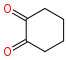

In [70]:
s1 = Molecule().fromSMILES('C1CCCC(=O)C1=O')
s1

In [71]:
calculateCyclicSymmetryNumber(s1)

2

**correct**

***

this should have a symmetry number of 2

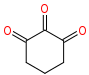

In [72]:
s1 = Molecule().fromSMILES('C1CCC(=O)C(=O)C1=O')
s1

In [73]:
calculateCyclicSymmetryNumber(s1)

3

**wrong**

***

this should have a symmetry number of 3

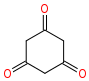

In [74]:
s1 = Molecule().fromSMILES('C1C(=O)CC(=O)CC1=O')
s1

In [75]:
calculateCyclicSymmetryNumber(s1)

3

**correct**

***

this should have a symmetry number of 2

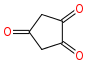

In [78]:
s1 = Molecule().fromSMILES('C1C(=O)C(=O)CC1=O')
s1

In [79]:
calculateCyclicSymmetryNumber(s1)

2

**correct**

***

this should have a symmetry number of 2

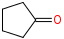

In [82]:
s1 = Molecule().fromSMILES('C1CCCC1=O')
s1

In [83]:
calculateCyclicSymmetryNumber(s1)

1

**wrong**

***

this should have a symmetry number of 1

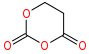

In [87]:
s1 = Molecule().fromSMILES('C1COC(=O)OC1=O')
s1

In [88]:
calculateCyclicSymmetryNumber(s1)

2

**wrong**

***

this should have a symmetry number of 2

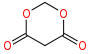

In [91]:
s1 = Molecule().fromSMILES('O1COC(=O)CC1=O')
s1

In [90]:
calculateCyclicSymmetryNumber(s1)

2

**correct**

# in depth: one different group

The molecule should have a symmetry of 2 (the axis of symmetry down the molecule). The program only returns a value of 1

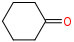

In [12]:
non_aromatic = Molecule().fromSMILES('C1CCCCC1=O')
structure = non_aromatic.copy(True)
non_aromatic

In [15]:
ring = structure.getSmallestSetOfSmallestRings()[0]

In [39]:
symmetryNumber = 1

# remove bonds in ring
for i, atom1 in enumerate(ring):
    for atom2 in ring[i+1:]:
        if structure.hasBond(atom1, atom2):
            structure.removeBond(atom1.edges[atom2])

In [19]:
structures = structure.split()
structures

[Molecule(SMILES="[C-]#[O+]", multiplicity=-187),
 Molecule(SMILES="C", multiplicity=-187),
 Molecule(SMILES="C", multiplicity=-187),
 Molecule(SMILES="C", multiplicity=-187),
 Molecule(SMILES="C", multiplicity=-187),
 Molecule(SMILES="C", multiplicity=-187)]

In [20]:
# find what is attached to each carbon
groups = []
for struct in structures:
    for atom in ring:
        if struct.hasAtom(atom): struct.removeAtom(atom)
    groups.append(struct.split())

In [21]:
groups

[[Molecule(SMILES="O", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)]]

In [22]:
# group the same groups together

equivalentGroups = []; equivalentGroupCount = []
for group in groups:
    found = False
    for i, eqGroup in enumerate(equivalentGroups):
        if not found and len(group) == len(eqGroup):
            for g, eg in zip(group, eqGroup):
                if not g.isIsomorphic(eg):
                    # The groups do not match
                    break
            else:
                # The groups match
                found = True
        if found:
            # We've found a matching group, so increment its count
            equivalentGroupCount[i] += 1        
            break
    else:
        # No matching group found, so add it as a new group
        equivalentGroups.append(group)
        equivalentGroupCount.append(1)

In [24]:
equivalentGroups

[[Molecule(SMILES="O", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)]]

Why is it finding the last two as different?

In [25]:
equivalentGroupCount

[1, 2, 3]

In [32]:
# find bond symmetry on ring

ring0 = non_aromatic.getSmallestSetOfSmallestRings()[0]
molecule = non_aromatic

equivalentBonds = []
for i, atom1 in enumerate(ring0):
    for atom2 in ring0[i+1:]:
        if molecule.hasBond(atom1, atom2):
            bond = molecule.getBond(atom1, atom2)
            found = False
            for eqBond in equivalentBonds:
                if not found:
                    if bond.equivalent(eqBond[0]):
                        eqBond.append(group)
                        found = True
            if not found:
                equivalentBonds.append([bond])

In [33]:
equivalentBonds

[[<Bond "S">,
  [Molecule(SMILES="[HH]", multiplicity=-187),
   Molecule(SMILES="[HH]", multiplicity=-187)],
  [Molecule(SMILES="[HH]", multiplicity=-187),
   Molecule(SMILES="[HH]", multiplicity=-187)],
  [Molecule(SMILES="[HH]", multiplicity=-187),
   Molecule(SMILES="[HH]", multiplicity=-187)],
  [Molecule(SMILES="[HH]", multiplicity=-187),
   Molecule(SMILES="[HH]", multiplicity=-187)],
  [Molecule(SMILES="[HH]", multiplicity=-187),
   Molecule(SMILES="[HH]", multiplicity=-187)]]]

In [34]:
minEquivalentGroups = min(equivalentGroupCount)
maxEquivalentGroups = max(equivalentGroupCount)
minEquivalentBonds = None
maxEquivalentBonds = 0

In [43]:
minEquivalentGroups

1

In [44]:
maxEquivalentGroups

3

In [35]:
for bonds in equivalentBonds:
    N = len(bonds)
    if minEquivalentBonds is None or N < minEquivalentBonds:
        minEquivalentBonds = N
    if N > maxEquivalentBonds:
        maxEquivalentBonds = N

In [41]:
minEquivalentBonds

6

In [42]:
maxEquivalentBonds

6

In [40]:
if maxEquivalentGroups == maxEquivalentBonds == len(ring):
    symmetryNumber *= len(ring) * 2
else:
    symmetryNumber *= min(minEquivalentGroups, minEquivalentBonds)


Note that the molecule is assumed to not have symmetry since it only found a minimum of one equivalent group

# in depth: 3 different groups

In [2]:
from rdkit.Chem.rdmolops import SanitizeMol
from rdkit.Chem.rdchem import Mol 
import rmgpy.molecule
from rmgpy.molecule import Molecule

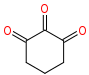

In [45]:
non_aromatic = Molecule().fromSMILES('C1CCC(=O)C(=O)C1=O')
structure = non_aromatic.copy(True)
non_aromatic

In [46]:
ring = structure.getSmallestSetOfSmallestRings()[0]

In [47]:
symmetryNumber = 1

# remove bonds in ring
for i, atom1 in enumerate(ring):
    for atom2 in ring[i+1:]:
        if structure.hasBond(atom1, atom2):
            structure.removeBond(atom1.edges[atom2])

In [48]:
structures = structure.split()
structures

[Molecule(SMILES="C", multiplicity=-187),
 Molecule(SMILES="C", multiplicity=-187),
 Molecule(SMILES="C", multiplicity=-187),
 Molecule(SMILES="[C-]#[O+]", multiplicity=-187),
 Molecule(SMILES="[C-]#[O+]", multiplicity=-187),
 Molecule(SMILES="[C-]#[O+]", multiplicity=-187)]

In [49]:
# find what is attached to each carbon
groups = []
for struct in structures:
    for atom in ring:
        if struct.hasAtom(atom): struct.removeAtom(atom)
    groups.append(struct.split())

In [50]:
groups

[[Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="O", multiplicity=-187)],
 [Molecule(SMILES="O", multiplicity=-187)],
 [Molecule(SMILES="O", multiplicity=-187)]]

In [51]:
# group the same groups together

equivalentGroups = []; equivalentGroupCount = []
for group in groups:
    found = False
    for i, eqGroup in enumerate(equivalentGroups):
        if not found and len(group) == len(eqGroup):
            for g, eg in zip(group, eqGroup):
                if not g.isIsomorphic(eg):
                    # The groups do not match
                    break
            else:
                # The groups match
                found = True
        if found:
            # We've found a matching group, so increment its count
            equivalentGroupCount[i] += 1        
            break
    else:
        # No matching group found, so add it as a new group
        equivalentGroups.append(group)
        equivalentGroupCount.append(1)

In [52]:
equivalentGroups

[[Molecule(SMILES="[HH]", multiplicity=-187),
  Molecule(SMILES="[HH]", multiplicity=-187)],
 [Molecule(SMILES="O", multiplicity=-187)]]

Why is it finding the last two as different?

In [53]:
equivalentGroupCount

[3, 3]

In [54]:
# find bond symmetry on ring

ring0 = non_aromatic.getSmallestSetOfSmallestRings()[0]
molecule = non_aromatic

equivalentBonds = []
for i, atom1 in enumerate(ring0):
    for atom2 in ring0[i+1:]:
        if molecule.hasBond(atom1, atom2):
            bond = molecule.getBond(atom1, atom2)
            found = False
            for eqBond in equivalentBonds:
                if not found:
                    if bond.equivalent(eqBond[0]):
                        eqBond.append(group)
                        found = True
            if not found:
                equivalentBonds.append([bond])

In [55]:
equivalentBonds

[[<Bond "S">,
  [Molecule(SMILES="O", multiplicity=-187)],
  [Molecule(SMILES="O", multiplicity=-187)],
  [Molecule(SMILES="O", multiplicity=-187)],
  [Molecule(SMILES="O", multiplicity=-187)],
  [Molecule(SMILES="O", multiplicity=-187)]]]

In [56]:
minEquivalentGroups = min(equivalentGroupCount)
maxEquivalentGroups = max(equivalentGroupCount)
minEquivalentBonds = None
maxEquivalentBonds = 0

In [57]:
minEquivalentGroups

3

In [58]:
maxEquivalentGroups

3

In [59]:
for bonds in equivalentBonds:
    N = len(bonds)
    if minEquivalentBonds is None or N < minEquivalentBonds:
        minEquivalentBonds = N
    if N > maxEquivalentBonds:
        maxEquivalentBonds = N

In [60]:
minEquivalentBonds

6

In [61]:
maxEquivalentBonds

6

In [62]:
if maxEquivalentGroups == maxEquivalentBonds == len(ring):
    symmetryNumber *= len(ring) * 2
else:
    symmetryNumber *= min(minEquivalentGroups, minEquivalentBonds)


In [63]:
symmetryNumber

3

Note that the molecule is assumed to have extra symmetry since it has a minimum of 3 identical groups